# Projet Leyenda : Livrable 1

### Groupe 2 :
- Brenda DJIGUEMDE
- Bruno DIAS
- Romaric DEMBELE
- Dany KHADAR

## Contexte


TouNum est une entreprise de numérisation de documents (textes, images...) et elle est souvent sollicitée par d'autres entreprises pour numériser leur base de documents papier. Certains de leurs clients ont une grande quantité de données à numériser, et un service de catégorisation automatique serait plus que valorisable. L'entreprise nous fait appel pour travailler sur une solution visant à analyser des photographies pour en déterminer une légende descriptive de manière automatique (du captioning).

Ceci dit, il y a deux challenges à relever, en plus de cet étiquetage proprement dit. Tout d'abord, la numérisation se faisant à la chaîne et sur des images de qualité variable (parfois floues, ou bruitées), il faudra tout d'abord voir ce qu'on peut faire pour nettoyer ces images. Et puis, TouNum a déjà numérisé beaucoup de documents sur lesquels ils souhaitent faire tourner les algorithmes d'apprentissage que nous allons concevoir. Or, Certaines de ces images ne sont pas des photos, mais parfois des images de documents composés, ou des schémas, voire des dessins ou des peintures. Il faudrait donc qu'on puisse, en amont de l'analyse de contenu, faire le tri entre les photos et le reste.

Heureusement, Tounum a déjà quelques milliers d'images catégorisées et étiquetées. Voilà qui devrait être utile pour effectuer de l'apprentissage supervisé.

## Objectif du livrable


L'entreprise voulant automatiser la sélection de photos pour l'annotations, ce livrable fournira une méthode de classification se basant sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos du dataset de départ. La solution s'appuyera sur l'architecture de réseau de neurones que nous aurons choisi et justifié notamment du point de vue des résultats obtenus.

TouNum a déjà classé un certain nombre d'images, nous aurons donc un dataset d'images catégorisées pour entraîner votre réseau de neurones.

## 1. Chargement des données et constitution du jeu de données

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Layer
from tensorflow.keras import Sequential

Le code suivant utilise TensorFlow pour charger un ensemble de données d'images à partir du répertoire './dataset_livrable_1'. Les images sont redimensionnées à 64x64 pour réduire la complexité computationnelle et pour la compatibilité avec certaines architectures de modèles. Un lot de 16 images est utilisé pour équilibrer l'utilisation de la mémoire et la vitesse d'entraînement. Le code réserve également 20% des données pour la validation, utilise un seed pour la reproductibilité, mélange les données pour éviter la mémorisation de l'ordre des échantillons, et retourne les labels en tant qu'entiers pour la classification.

In [ ]:
# Dataset parameters
image_size = (64, 64)               
batch_size = 16     
dataset_path = './dataset_livrable_1'   

# Load the dataset
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,   
    validation_split=0.2,   
    subset="training", 
    seed=123,  
    shuffle=True,  
    image_size=image_size, 
    batch_size=batch_size,     
    label_mode='int'  
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'  
)

Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


Le code suivant récupère et affiche les noms des classes à partir de l'ensemble de données d'entraînement.

In [ ]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


Le code suivant calcule et affiche la distribution des classes dans l'ensemble de données d'entraînement. Afin de vérifier qu'il y a une bonne distribution des données dans le jeu de test et de train.

In [ ]:
import numpy as np

class_counts = np.zeros(len(class_names))

def get_class_distribution(dataset):
    for images, labels in dataset:
        for label in labels:
            class_counts[label.numpy()] += 1

    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

get_class_distribution(train_set)

Painting: 7968.0
Photo: 7946.0
Schematics: 8045.0
Sketch: 1118.0
Text: 8042.0


In [ ]:
get_class_distribution(test_set)

Painting: 2031.0
Photo: 2047.0
Schematics: 1955.0
Sketch: 288.0
Text: 1958.0


Le code suivant convertit les étiquettes de l'ensemble de données d'entraînement et de test en format binaire, spécifiquement pour distinguer les images qui sont des photos (étiquetées comme '1') de celles qui ne le sont pas (étiquetées comme '0'), en se basant sur le nom du dossier cible 'Photo'. Les ensembles de données modifiés sont ensuite affichés.

In [ ]:
# Nom du dossier cible 
target_folder_name = 'Photo'

# Trouve l'index du label basé sur le nom du dossier
target_label = train_set.class_names.index(target_folder_name)

def binary_label(images, labels):
    """Fonction pour convertir les étiquettes en format binaire."""
    binary_labels = tf.where(labels == target_label, 1, 0)
    return images, binary_labels

# Applique la fonction de prétraitement aux jeux de données
train_set = train_set.map(binary_label)
test_set = test_set.map(binary_label)

print(train_set)
print(test_set)

<_MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Le code suivant prend un lot d'images de l'ensemble de données d'entraînement et imprime leurs étiquettes. C'est utile pour vérifier que les étiquettes ont été correctement assignées.

In [ ]:
for images, labels in train_set.take(1):
    print(labels)

tf.Tensor([1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0], shape=(16,), dtype=int32)


## 2. Visualisation des données

Ce code affiche les neuf premières images de deux lots de l'ensemble de données d'entraînement, avec leurs étiquettes respectives, en utilisant Matplotlib.

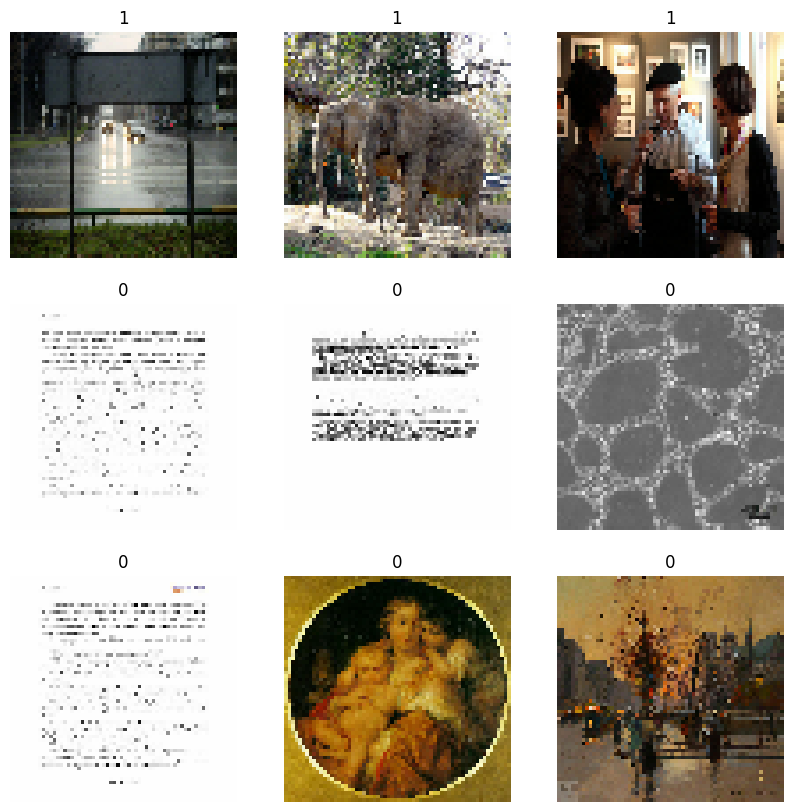

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")

## 3. Normalisation des données pour l'entrainement

Le code suivant applique une normalisation à l'ensemble de données d'entraînement et de test, en redimensionnant les valeurs des pixels des images entre 0 et 1, pour faciliter l'entraînement du modèle.

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_set = train_set.map(lambda x, y: (normalization_layer(x), y))
test_set = test_set.map(lambda x, y: (normalization_layer(x), y))

## 4. Le modèle de réseau de neurones convolutif (CNN)

On utilise les CNNs car elles permettent l'extraction de caractéristiques spatiales à partir d'images. La code suivant crée un modèle de réseau de neurones convolutif (CNN) en utilisant TensorFlow et Keras, ce qui est idéal pour notre tâche de classification d'images. La forme d'entrée du modèle est définie en fonction des images de l'ensemble de données. L'architecture comprend deux couches de convolution avec 32 et 64 filtres respectivement, chacune suivie d'une couche de pooling max pour réduire la dimensionnalité spatiale. Les caractéristiques sont ensuite aplaties et passées à travers une couche dense de 128 neurones. La couche de sortie utilise une activation sigmoïde pour prédire une classe binaire. Ce modèle est assez simple, car il s'agit d'un premier essai, et les paramètres seront ajustés pour améliorer les performances dans les itérations ultérieures.

### 4.1 Le modèle de base

In [12]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

Le code suivant crée et compile un modèle CNN pour une tâche de classification binaire d'images. L'optimiseur 'adam' est choisi pour sa capacité à gérer les grands problèmes et à converger rapidement, ce qui le rend préférable à d'autres optimiseurs comme SGD. La fonction de perte 'binary_crossentropy' est utilisée car elle est spécifiquement conçue pour les tâches de classification binaire, la rendant plus appropriée que d'autres fonctions de perte comme la perte quadratique moyenne (MSE).

In [13]:
model = create_model((64, 64, 3))
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Le code suivant entraîne le modèle de réseau de neurones convolutif (CNN) sur un ensemble de données d'entraînement (`train_set`) pour un nombre spécifié d'époques (10 dans ce cas). Pendant l'entraînement, le modèle est également validé sur un ensemble de données de test (`test_set`). Les résultats de l'entraînement et de la validation à chaque époque sont stockés dans la variable `history`.

In [14]:
# Train the model
history = model.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 128s 61ms/step - accuracy: 0.8076 - loss: 0.3641 - val_accuracy: 0.8604 - val_loss: 0.2965
Epoch 2/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 122s 59ms/step - accuracy: 0.8749 - loss: 0.2651 - val_accuracy: 0.8958 - val_loss: 0.2456
Epoch 3/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 122s 59ms/step - accuracy: 0.9106 - loss: 0.2081 - val_accuracy: 0.8888 - val_loss: 0.2598
Epoch 4/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step - accuracy: 0.9299 - loss: 0.1641 - val_accuracy: 0.8991 - val_loss: 0.2575
Epoch 5/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 122s 59ms/step - accuracy: 0.9527 - loss: 0.1199 - val_accuracy: 0.9055 - val_loss: 0.2882
Epoch 6/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step - accuracy: 0.9678 - loss: 0.0828 - val_accuracy: 0.8915 - val_loss: 0.3702
Epoch 7/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 123s 59ms/step - accuracy: 0.9787 - loss: 0.0580 - val_accuracy: 0.8979 - val_loss: 0.3678
Epoch 8/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 124s 60ms/step - accuracy: 

Le code suivant génère deux graphiques pour visualiser la précision et la perte d'entraînement et de validation du modèle de réseau de neurones convolutif (CNN) au fil des époques. 

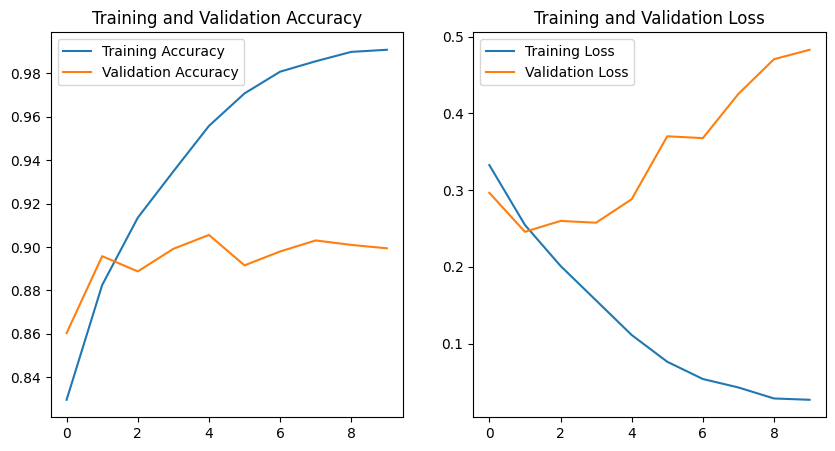

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Le modèle montre une augmentation constante de la précision d'entraînement, indiquant une bonne adaptation aux données d'entraînement, tandis que la précision de validation augmente initialement mais se stabilise autour de 90%, suggérant un possible surajustement. 

La courbe de perte d'entraînement décroît régulièrement, ce qui est attendu lors d'un apprentissage efficace. Cependant, la perte de validation fluctue et a tendance à augmenter, ce qui peut indiquer un apprentissage instable et une mauvaise généralisation à des données non vues.

Le code suivant permet de comparer visuellement les prédictions du modèle avec les vraies valeurs pour évaluer la performance du modèle.

In [16]:
for images, labels in test_set.take(1):
    preds = model.predict(images)
    print("Predictions:", preds)
    print("Actual labels:", labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predictions: [[1.1408632e-10]
 [4.8430881e-01]
 [3.8003531e-16]
 [1.7765854e-20]
 [9.9999124e-01]
 [1.0000000e+00]
 [9.8857158e-01]
 [1.7130125e-08]
 [9.9977458e-01]
 [9.9999976e-01]
 [1.2784490e-03]
 [9.9542499e-01]
 [1.2282878e-20]
 [1.5008833e-07]
 [4.4413746e-21]
 [4.3225663e-28]]
Actual labels: [0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0]


Le code suivant prédit les labels de l'ensemble de test à l'aide du modèle entraîné, calcule une matrice de confusion en comparant les prédictions aux labels réels, et affiche cette matrice. Les prédictions sont ajustées en fonction d'un seuil (ici 0,5). La matrice de confusion est utilisée pour évaluer par la suite la performance du modèle.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

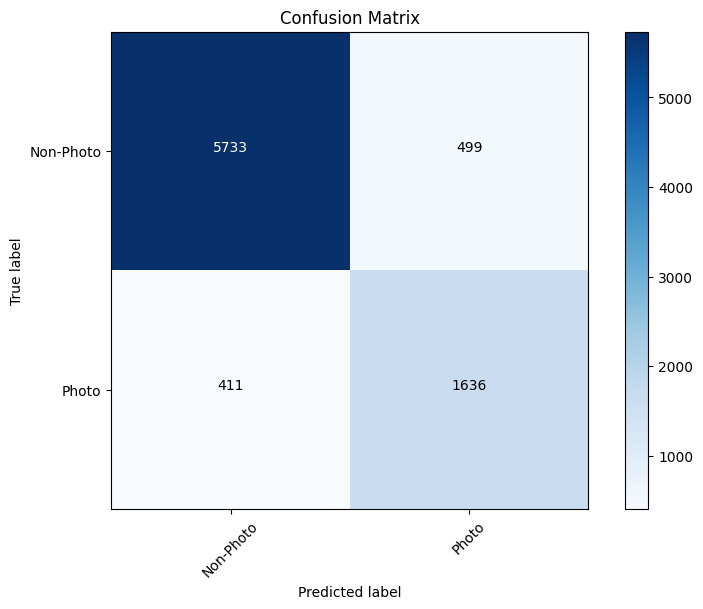

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

y_pred_prob = []
y_true = []
for images, labels in test_set:

    preds = model.predict(images)
    y_pred_prob.extend(preds)
    y_true.extend(labels.numpy().astype(int))

# Fonction pour calculer et afficher la matrice de confusion
def calculate_and_plot_confusion_matrix(y_true, y_pred_prob, threshold, class_names):

    y_pred_adjusted = (np.array(y_pred_prob) > threshold).astype(int)

    new_cm = confusion_matrix(y_true, y_pred_adjusted)

    plot_confusion_matrix(new_cm, class_names)

# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, class_names):
    """
    Affiche une matrice de confusion avec une coloration spécifique et des annotations.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#seuil pour tester
threshold = 0.5  

calculate_and_plot_confusion_matrix(y_true, y_pred_prob, threshold, class_names=['Non-Photo', 'Photo'])

La matrice de confusion indique :

1. **Vrais négatifs** (en haut à gauche) : 5733 non-photos correctement identifiées.
2. **Faux positifs** (en haut à droite) : 499 non-photos incorrectement classées comme photos.
3. **Faux négatifs** (en bas à gauche) : 411 photos incorrectement classées comme non-photos.
4. **Vrais positifs** (en bas à droite) : 1636 photos correctement identifiées.

Le code suivant calcule et affiche quatre métriques pour évaluer la performance du modèle de classification binaire :

1. **Précision** : Proportion de prédictions positives qui sont réellement positives.
2. **Rappel** : Proportion de vrais positifs qui sont correctement identifiés par le modèle.
3. **Score F1** : Moyenne harmonique de la précision et du rappel, offrant un équilibre entre ces deux métriques.
4. **AUC** (Area Under the ROC Curve) : Mesure la capacité du modèle à distinguer entre les classes. Une valeur de 1.0 indique une performance parfaite.

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculer les métriques en utilisant le seuil ajusté pour la classification binaire
def calculate_metrics(y_true, y_pred_prob, threshold):
    # Convertissez les probabilités en prédictions binaires basées sur le seuil
    y_pred_adjusted = (np.array(y_pred_prob) > threshold).astype(int)

    # Calculer les métriques
    precision = precision_score(y_true, y_pred_adjusted)
    recall = recall_score(y_true, y_pred_adjusted)
    f1 = f1_score(y_true, y_pred_adjusted)
    # Calcul de l'AUC nécessite les scores de probabilité, pas les prédictions binaires
    auc = roc_auc_score(y_true, y_pred_prob)

    return precision, recall, f1, auc

# Ajuster le seuil de classification si nécessaire
threshold = 0.5

# Calculer les métriques
precision, recall, f1, auc = calculate_metrics(y_true, y_pred_prob, threshold)

# Afficher les métriques
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Precision: 0.7663
Recall: 0.7992
F1 Score: 0.7824
AUC: 0.9475


Le modèle présente des valeurs de précision, recall, F1 et AUC correctes. Toute fois nous allons essayer par la suite améliorer ce modèle pour éviter le 
surraprentissage identifié plus tôt en utilisant des techniques de régularisation et en modifiant les hyper paramètres. 

### 4.2 Le modèle L1

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2070/2070 ━━━━━━━━━━━━━━━━━━━━ 130s 62ms/step - accuracy: 0.7537 - loss: 8.0314 - val_accuracy: 0.7527 - val_loss: 2.4504
Epoch 2/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 131s 63ms/step - accuracy: 0.7627 - loss: 2.4100 - val_accuracy: 0.7527 - val_loss: 2.4065
Epoch 3/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 128s 62ms/step - accuracy: 0.7627 - loss: 2.3881 - val_accuracy: 0.7527 - val_loss: 2.4166
Epoch 4/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 119s 58ms/step - accuracy: 0.7628 - loss: 2.3841 - val_accuracy: 0.7527 - val_loss: 2.3788
Epoch 5/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 115s 56ms/step - accuracy: 0.7623 - loss: 2.3808 - val_accuracy: 0.7527 - val_loss: 2.4068
Epoch 6/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 116s 56ms/step - accuracy: 0.7628 - loss: 2.3775 - val_accuracy: 0.7527 - val_loss: 2.3921
Epoch 7/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 115s 56ms/step - accuracy: 0.7629 - loss: 2.3724 - val_accuracy: 0.7527 - val_loss: 2.4049
Epoch 8/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 115s 56ms/step - accuracy: 0.7627 - lo

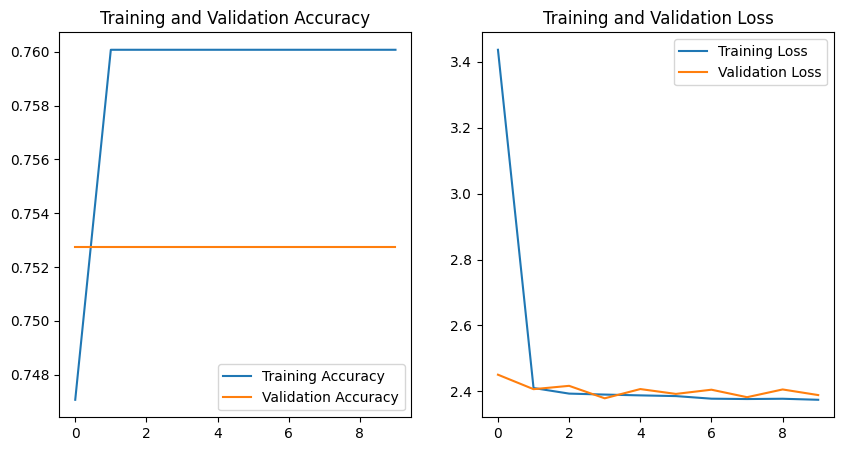

In [35]:
def create_model_l1(input_shape):

    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    return model

model_l1 = create_model_l1((64, 64, 3))
model_l1.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

model_l1.summary()

history_l1 = model_l1.fit(train_set, epochs=10, validation_data=test_set)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_l1.history['accuracy'], label='Training Accuracy')
plt.plot(history_l1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_l1.history['loss'], label='Training Loss')
plt.plot(history_l1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

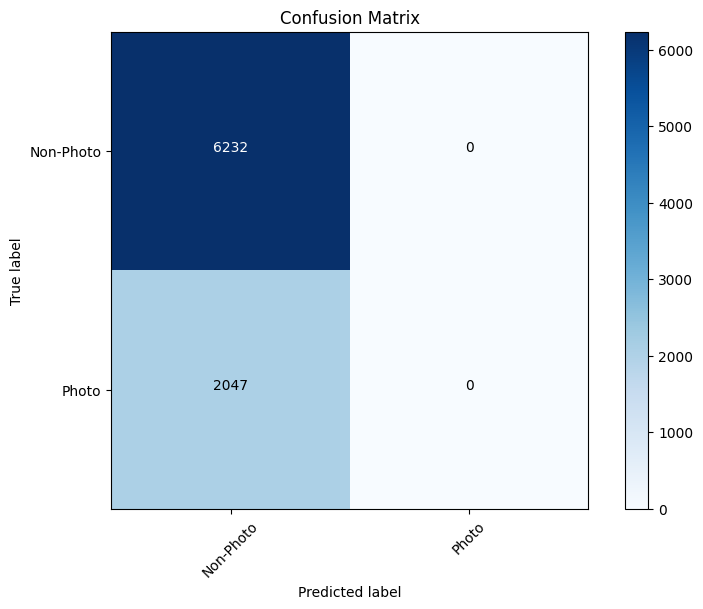

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.7829


c:\Users\danyk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
y_pred_prob_l1 = []
y_true_l1 = []
for images, labels in test_set:

    preds = model_l1.predict(images)
    y_pred_prob_l1.extend(preds)
    y_true_l1.extend(labels.numpy().astype(int))

threshold = 0.5

calculate_and_plot_confusion_matrix(y_true_l1, y_pred_prob_l1, threshold, class_names=['Non-Photo', 'Photo'])

precision_l1, recall_l1, f1_l1, auc_l1 = calculate_metrics(y_true_l1, y_pred_prob_l1, threshold)

print(f"Precision: {precision_l1:.4f}")
print(f"Recall: {recall_l1:.4f}")
print(f"F1 Score: {f1_l1:.4f}")
print(f"AUC: {auc_l1:.4f}")

### 4.3 Le modèle L2

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 134s 64ms/step - accuracy: 0.7608 - loss: 0.6159 - val_accuracy: 0.7893 - val_loss: 0.4109
Epoch 2/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 127s 61ms/step - accuracy: 0.7880 - loss: 0.3921 - val_accuracy: 0.7889 - val_loss: 0.4082
Epoch 3/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 128s 62ms/step - accuracy: 0.7959 - loss: 0.3800 - val_accuracy: 0.7979 - val_loss: 0.3811
Epoch 4/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 127s 61ms/step - accuracy: 0.8012 - loss: 0.3757 - val_accuracy: 0.8009 - val_loss: 0.3823
Epoch 5/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 120s 58ms/step - accuracy: 0.8021 - loss: 0.3738 - val_accuracy: 0.8026 - val_loss: 0.3767
Epoch 6/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 129s 62ms/step - accuracy: 0.8058 - loss: 0.3719 - val_accuracy: 0.8018 - val_loss: 0.3826
Epoch 7/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 130s 63ms/step - accuracy: 0.8132 - loss: 0.3694 - val_accuracy: 0.8028 - val_loss: 0.3897
Epoch 8/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 130s 63ms/step - accuracy: 

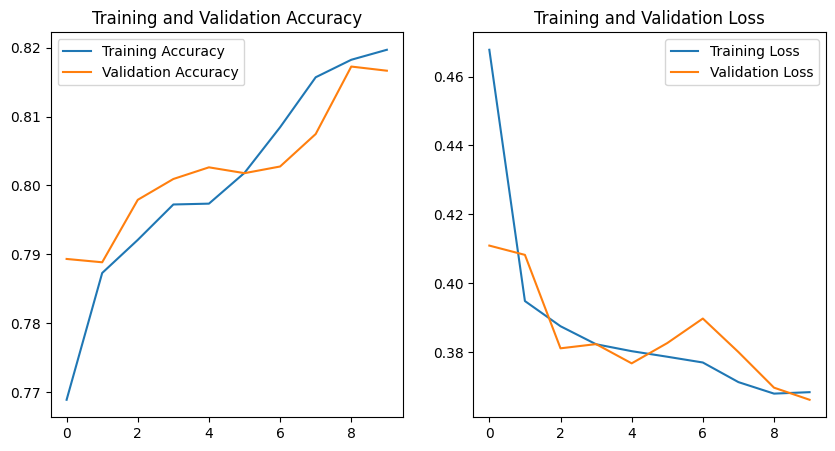

In [40]:
def create_model_l2(input_shape):
    
        inputs = Input(shape=input_shape)
        x = Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
        x = MaxPooling2D()(x)
        x = Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = MaxPooling2D()(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs, outputs)
        return model

model_l2 = create_model_l2((64, 64, 3))
model_l2.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

model_l2.summary()

history_l2 = model_l2.fit(train_set, epochs=10, validation_data=test_set)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_l2.history['accuracy'], label='Training Accuracy')
plt.plot(history_l2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_l2.history['loss'], label='Training Loss')
plt.plot(history_l2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

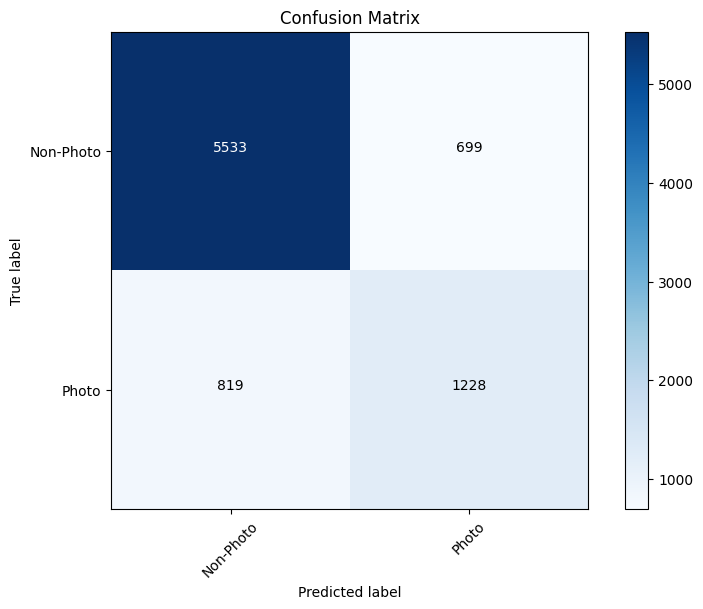

Precision: 0.6373
Recall: 0.5999
F1 Score: 0.6180
AUC: 0.8894


In [41]:
y_pred_prob_l2 = []
y_true_l2 = []

for images, labels in test_set:
    
        preds = model_l2.predict(images)
        y_pred_prob_l2.extend(preds)
        y_true_l2.extend(labels.numpy().astype(int))

threshold = 0.5

calculate_and_plot_confusion_matrix(y_true_l2, y_pred_prob_l2, threshold, class_names=['Non-Photo', 'Photo'])

precision_l2, recall_l2, f1_l2, auc_l2 = calculate_metrics(y_true_l2, y_pred_prob_l2, threshold)

print(f"Precision: {precision_l2:.4f}")
print(f"Recall: {recall_l2:.4f}")
print(f"F1 Score: {f1_l2:.4f}")
print(f"AUC: {auc_l2:.4f}")

### 4.4 Le modèle Dropout

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 116s 56ms/step - accuracy: 0.7866 - loss: 0.3927 - val_accuracy: 0.8509 - val_loss: 0.3108
Epoch 2/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 101s 49ms/step - accuracy: 0.8501 - loss: 0.3050 - val_accuracy: 0.8861 - val_loss: 0.2628
Epoch 3/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 102s 49ms/step - accuracy: 0.8804 - loss: 0.2655 - val_accuracy: 0.8537 - val_loss: 0.3784
Epoch 4/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 106s 51ms/step - accuracy: 0.8950 - loss: 0.2399 - val_accuracy: 0.9014 - val_loss: 0.2297
Epoch 5/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - accuracy: 0.9074 - loss: 0.2161 - val_accuracy: 0.9034 - val_loss: 0.2448
Epoch 6/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 101s 49ms/step - accuracy: 0.9202 - loss: 0.1918 - val_accuracy: 0.9023 - val_loss: 0.2515
Epoch 7/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 103s 50ms/step - accuracy: 0.9292 - loss: 0.1716 - val_accuracy: 0.9001 - val_loss: 0.2524
Epoch 8/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 101s 49ms/step - accuracy: 

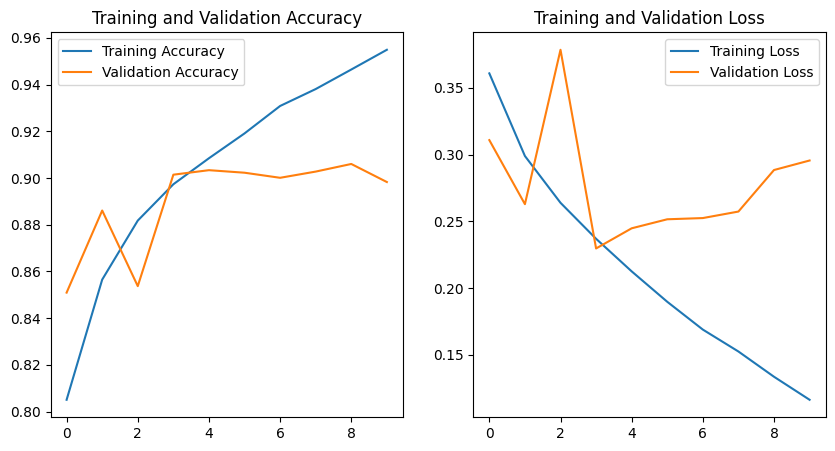

In [22]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model_dropout = Model(inputs, outputs)
    return model_dropout

model_dropout = create_model((64, 64, 3))
model_dropout.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

model_dropout.summary()

history = model_dropout.fit(train_set, epochs=10, validation_data=test_set)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

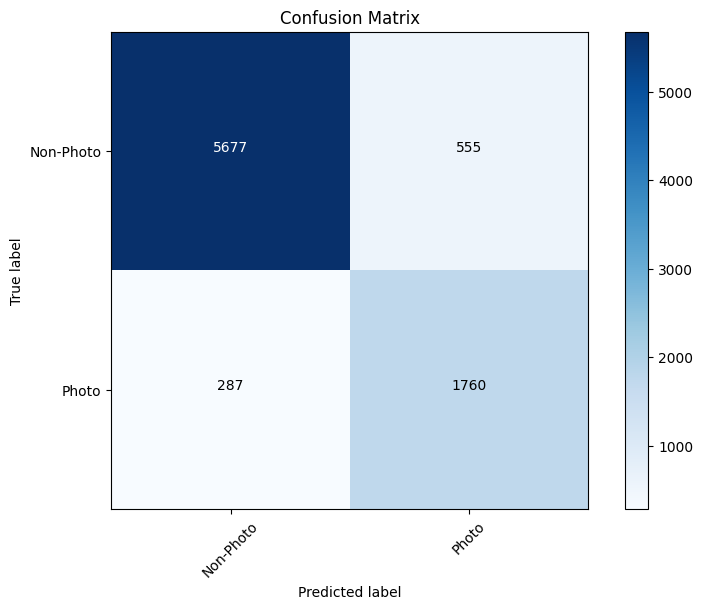

Precision: 0.7603
Recall: 0.8598
F1 Score: 0.8070
AUC: 0.9569


In [37]:
y_pred_prob_dropout = []
y_true_dropout = []
for images, labels in test_set:

    preds = model_dropout.predict(images)
    y_pred_prob_dropout.extend(preds)
    y_true_dropout.extend(labels.numpy().astype(int))

threshold = 0.5

calculate_and_plot_confusion_matrix(y_true_dropout, y_pred_prob_dropout, threshold, class_names=['Non-Photo', 'Photo'])

precision_dropout, recall_dropout, f1_dropout, auc_dropout = calculate_metrics(y_true_dropout, y_pred_prob_dropout, threshold)

print(f"Precision: {precision_dropout:.4f}")
print(f"Recall: {recall_dropout:.4f}")
print(f"F1 Score: {f1_dropout:.4f}")
print(f"AUC: {auc_dropout:.4f}")

### 4.5 Le modèle EarlyStopping

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 107s 51ms/step - accuracy: 0.7861 - loss: 0.3910 - val_accuracy: 0.8416 - val_loss: 0.3086
Epoch 2/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 112s 54ms/step - accuracy: 0.8536 - loss: 0.3005 - val_accuracy: 0.8782 - val_loss: 0.2873
Epoch 3/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 108s 52ms/step - accuracy: 0.8809 - loss: 0.2669 - val_accuracy: 0.8936 - val_loss: 0.2473
Epoch 4/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 99s 48ms/step - accuracy: 0.8968 - loss: 0.2383 - val_accuracy: 0.8960 - val_loss: 0.2493
Epoch 5/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 111s 53ms/step - accuracy: 0.9073 - loss: 0.2130 - val_accuracy: 0.9025 - val_loss: 0.2289
Epoch 6/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 102s 49ms/step - accuracy: 0.9184 - loss: 0.1948 - val_accuracy: 0.9036 - val_loss: 0.2422
Epoch 7/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 103s 50ms/step - accuracy: 0.9254 - loss: 0.1826 - val_accuracy: 0.8979 - val_loss: 0.2482


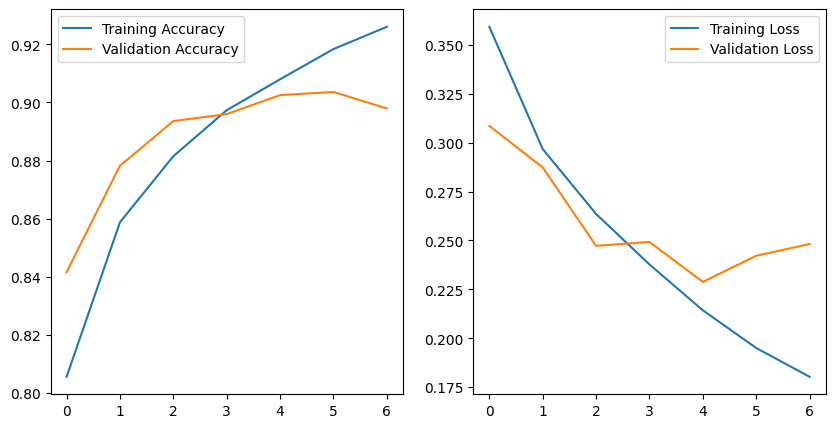

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model_early_stopping = create_model((64, 64, 3))
model_early_stopping.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

model_early_stopping.summary()

# Train the model
history = model_early_stopping.fit(train_set, epochs=10, validation_data=test_set, callbacks=[early_stopping])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()    

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

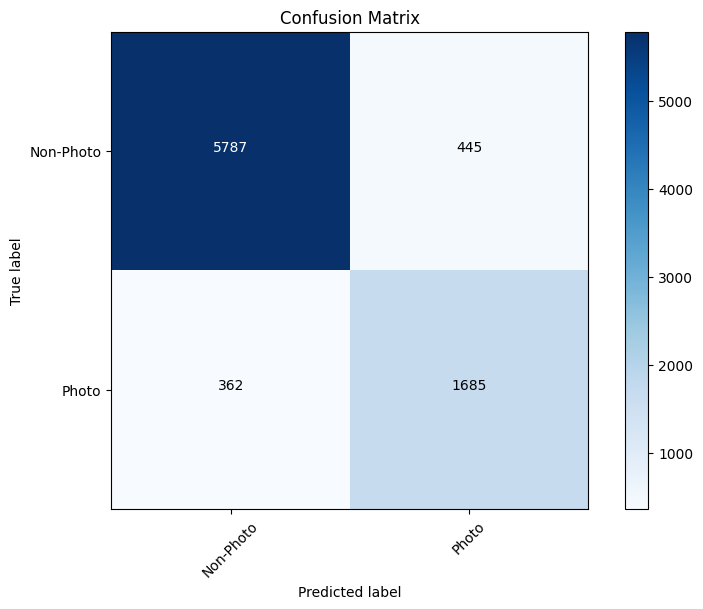

Precision: 0.7911
Recall: 0.8232
F1 Score: 0.8068
AUC: 0.9584


In [38]:
y_pred_prob_early_stopping = []
y_true_early_stopping = []

for images, labels in test_set:
    
        preds = model_early_stopping.predict(images)
        y_pred_prob_early_stopping.extend(preds)
        y_true_early_stopping.extend(labels.numpy().astype(int))

threshold = 0.5

calculate_and_plot_confusion_matrix(y_true_early_stopping, y_pred_prob_early_stopping, threshold, class_names=['Non-Photo', 'Photo'])

precision_early_stopping, recall_early_stopping, f1_early_stopping, auc_early_stopping = calculate_metrics(y_true_early_stopping, y_pred_prob_early_stopping, threshold)

print(f"Precision: {precision_early_stopping:.4f}")
print(f"Recall: {recall_early_stopping:.4f}")
print(f"F1 Score: {f1_early_stopping:.4f}")
print(f"AUC: {auc_early_stopping:.4f}")

### 4.6 Le modèle L2 + Dropout

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,281 (6.20 MB)

 Trainable params: 1,625,281 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 112s 54ms/step - accuracy: 0.9905 - loss: 0.0271 - val_accuracy: 0.8959 - val_loss: 0.5676
Epoch 2/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 117s 56ms/step - accuracy: 0.9914 - loss: 0.0247 - val_accuracy: 0.8936 - val_loss: 0.6038
Epoch 3/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 124s 60ms/step - accuracy: 0.9937 - loss: 0.0182 - val_accuracy: 0.8859 - val_loss: 0.7520
Epoch 4/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 119s 57ms/step - accuracy: 0.9928 - loss: 0.0228 - val_accuracy: 0.8838 - val_loss: 0.7242
Epoch 5/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 119s 58ms/step - accuracy: 0.9947 - loss: 0.0148 - val_accuracy: 0.8964 - val_loss: 0.6302
Epoch 6/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 102s 49ms/step - accuracy: 0.9934 - loss: 0.0220 - val_accuracy: 0.8915 - val_loss: 0.6909
Epoch 7/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 111s 54ms/step - accuracy: 0.9945 - loss: 0.0194 - val_accuracy: 0.8900 - val_loss: 0.6719
Epoch 8/10
2070/2070 ━━━━━━━━━━━━━━━━━━━━ 111s 53ms/step - accuracy: 

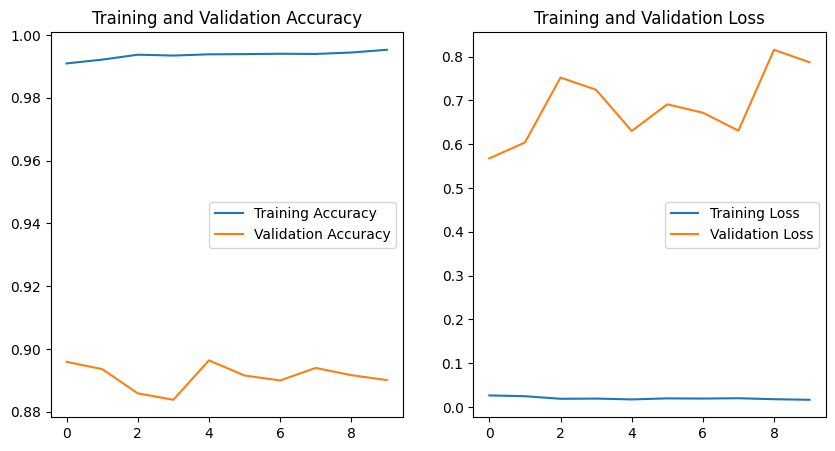

In [24]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model_L2_Dropout = Model(inputs, outputs)
    return model

model_L2_Dropout = create_model((64, 64, 3))
model_L2_Dropout.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model_L2_Dropout.summary()

history = model_L2_Dropout.fit(train_set, epochs=10, validation_data=test_set)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

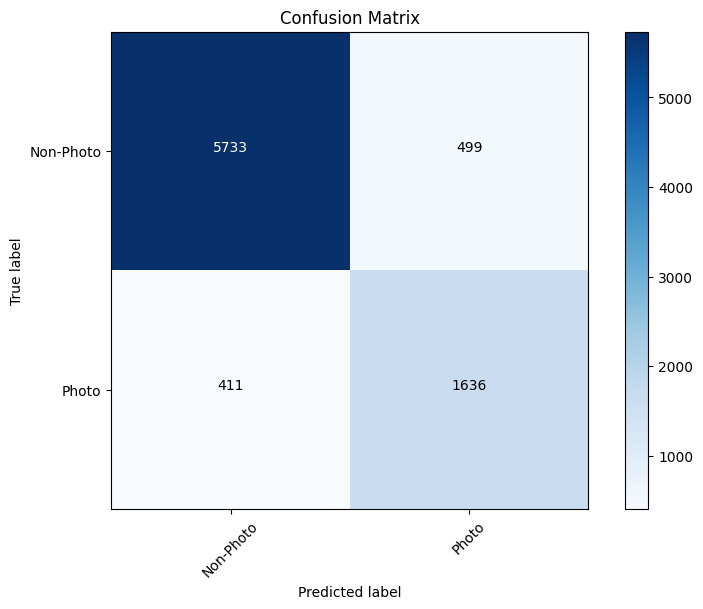

Precision: 0.7663
Recall: 0.7992
F1 Score: 0.7824
AUC: 0.9475


In [39]:
y_pred_prob_L2_Dropout = []
y_true_L2_Dropout = []
for images, labels in test_set:

    preds = model_L2_Dropout.predict(images)
    y_pred_prob_L2_Dropout.extend(preds)
    y_true_L2_Dropout.extend(labels.numpy().astype(int))

threshold = 0.5

calculate_and_plot_confusion_matrix(y_true_L2_Dropout, y_pred_prob_L2_Dropout, threshold, class_names=['Non-Photo', 'Photo'])

precision_L2_Dropout, recall_L2_Dropout, f1_L2_Dropout, auc_L2_Dropout = calculate_metrics(y_true_L2_Dropout, y_pred_prob_L2_Dropout, threshold)

print(f"Precision: {precision_L2_Dropout:.4f}")
print(f"Recall: {recall_L2_Dropout:.4f}")
print(f"F1 Score: {f1_L2_Dropout:.4f}")
print(f"AUC: {auc_L2_Dropout:.4f}")

In [46]:
from tensorflow import keras
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D())
        model.add(Conv2D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(units=hp.Int('units', min_value=64, max_value=256, step=64),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='binary_crossentropy',
            metrics=['accuracy'])
        
        return model

hypermodel = CNNHyperModel(input_shape=(64, 64, 3))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hparam_tuning')

tuner.search(train_set,
             epochs=10,
             validation_data=test_set)


Reloading Tuner from my_dir\hparam_tuning\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |64                |filters_1
5                 |3                 |kernel_size_1
96                |32                |filters_2
3                 |3                 |kernel_size_2
192               |192               |units
0.4               |0.5               |dropout
0.00055664        |0.00028108        |learning_rate

Epoch 1/10
  78/2070 ━━━━━━━━━━━━━━━━━━━━ 2:58 89ms/step - accuracy: 0.7671 - loss: 0.5136